In [1]:
import pandas as pd
import numpy as np

**Load Dataset**

In [2]:
file_path = "/content/airQuality.csv"
df = pd.read_csv(file_path)

# **Phase 1: Problem Definition & Data Preparation**

**Define Your Target Variable & Prediction Task**

Keep only PM2.5 measurements

In [3]:
pm25_df = df[df["parameter"] == "pm25"].copy()

Ensure datetime column is of datetime type

In [4]:
pm25_df["datetimeLocal"] = pd.to_datetime(pm25_df["datetimeLocal"])

Set datetime as index and compute daily mean

In [5]:
pm25_df.set_index("datetimeLocal", inplace=True)
daily_pm25 = pm25_df["value"].resample("D").mean().rename("pm25_avg")

***Regression Task***

In [6]:
regression_df = daily_pm25.to_frame()
regression_df["pm25_next_day"] = regression_df["pm25_avg"].shift(-1)
regression_df = regression_df.dropna()

print("Regression dataset (predict next day's PM2.5):")
print(regression_df.head())

Regression dataset (predict next day's PM2.5):
                             pm25_avg  pm25_next_day
datetimeLocal                                       
2016-02-05 00:00:00+05:30  132.000000     207.600000
2016-02-08 00:00:00+05:30  135.625000     191.857143
2016-02-09 00:00:00+05:30  191.857143     264.600000
2016-02-10 00:00:00+05:30  264.600000     118.111111
2016-02-11 00:00:00+05:30  118.111111     272.333333


***Classification Task***

In [7]:
def get_aqi_category(pm25: float) -> str:
    """Map PM2.5 (μg/m³) to NAQI category."""
    if pm25 <= 30:
        return "Good"
    elif pm25 <= 60:
        return "Satisfactory"
    elif pm25 <= 90:
        return "Moderate"
    elif pm25 <= 120:
        return "Poor"
    elif pm25 <= 250:
        return "Very Poor"
    else:
        return "Severe"

classification_df = daily_pm25.to_frame()
classification_df["aqi_category"] = classification_df["pm25_avg"].apply(get_aqi_category)
classification_df["aqi_next_day"] = classification_df["aqi_category"].shift(-1)
classification_df = classification_df.dropna()

print("\nClassification dataset (predict next day's AQI category):")
print(classification_df.head())


Classification dataset (predict next day's AQI category):
                             pm25_avg aqi_category aqi_next_day
datetimeLocal                                                  
2016-02-05 00:00:00+05:30  132.000000    Very Poor    Very Poor
2016-02-06 00:00:00+05:30  207.600000    Very Poor       Severe
2016-02-08 00:00:00+05:30  135.625000    Very Poor    Very Poor
2016-02-09 00:00:00+05:30  191.857143    Very Poor       Severe
2016-02-10 00:00:00+05:30  264.600000       Severe         Poor


**Data Loading & Initial Review**

In [8]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314430 entries, 0 to 314429
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   location_id    314430 non-null  int64  
 1   location_name  314430 non-null  object 
 2   parameter      314430 non-null  object 
 3   value          314430 non-null  float64
 4   unit           314430 non-null  object 
 5   datetimeUtc    314430 non-null  object 
 6   datetimeLocal  314430 non-null  object 
 7   timezone       314430 non-null  object 
 8   latitude       314430 non-null  float64
 9   longitude      314430 non-null  float64
 10  owner_name     314430 non-null  object 
 11  provider       314430 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 28.8+ MB
None


In [9]:
print("\nFirst 5 Rows:")
print(df.head())


First 5 Rows:
   location_id               location_name parameter  value unit  \
0         8235  Jahangirpuri, Delhi - DPCC        co   0.84  ppb   
1         8235  Jahangirpuri, Delhi - DPCC        co   0.81  ppb   
2         8235  Jahangirpuri, Delhi - DPCC        co   0.85  ppb   
3         8235  Jahangirpuri, Delhi - DPCC        co   0.92  ppb   
4         8235  Jahangirpuri, Delhi - DPCC        co   1.02  ppb   

            datetimeUtc              datetimeLocal      timezone  latitude  \
0  2025-05-15T00:15:00Z  2025-05-15T05:45:00+05:30  Asia/Kolkata  28.73282   
1  2025-05-15T00:30:00Z  2025-05-15T06:00:00+05:30  Asia/Kolkata  28.73282   
2  2025-05-15T00:45:00Z  2025-05-15T06:15:00+05:30  Asia/Kolkata  28.73282   
3  2025-05-15T01:00:00Z  2025-05-15T06:30:00+05:30  Asia/Kolkata  28.73282   
4  2025-05-15T01:15:00Z  2025-05-15T06:45:00+05:30  Asia/Kolkata  28.73282   

   longitude                         owner_name provider  
0  77.170633  Delhi Pollution Control Committee 

In [10]:
print("\nUnique Location in Dataset:")
print(df['location_name'].unique())


Unique Location in Dataset:
['Jahangirpuri, Delhi - DPCC' 'Wazirpur, Delhi - DPCC'
 'Anand Vihar, New Delhi - DPCC' 'Vivek Vihar, Delhi - DPCC'
 'Bawana, Delhi - DPCC']


In [11]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
         location_id          value       latitude      longitude
count  314430.000000  314430.000000  314430.000000  314430.000000
mean     6633.116411      79.266428      28.706153      77.202667
std      3174.470605     228.197882       0.045134       0.100530
min       235.000000       0.000000      28.646835      77.051074
25%      6938.000000      10.900000      28.672342      77.165453
50%      8235.000000      32.700000      28.699793      77.170633
75%      8472.000000      75.000000      28.732820      77.315260
max      8915.000000   13600.000000      28.776200      77.316032


**Temporal Data Splitting**

Convert datetimeUtc to timezone-aware datetime

In [12]:
df['datetimeUtc'] = pd.to_datetime(df['datetimeUtc'], utc=True)

Sort by datetime

In [13]:
df = df.sort_values('datetimeUtc')

Define training and testing date boundaries

In [14]:
train_start = pd.Timestamp('2014-01-01', tz='UTC')
train_end   = pd.Timestamp('2019-12-31 23:59:59', tz='UTC')

test_start  = pd.Timestamp('2020-01-01', tz='UTC')
test_end    = pd.Timestamp('2025-06-08 23:59:59', tz='UTC')

Split data

In [15]:
train_df = df[(df['datetimeUtc'] >= train_start) & (df['datetimeUtc'] <= train_end)]
test_df  = df[(df['datetimeUtc'] >= test_start)  & (df['datetimeUtc'] <= test_end)]

Display results

In [16]:
print("Training Set:")
print(f"Start Date: {train_df['datetimeUtc'].min()}")
print(f"End Date:   {train_df['datetimeUtc'].max()}")
print(f"Total Rows: {len(train_df)}")

print("\nTesting Set:")
print(f"Start Date: {test_df['datetimeUtc'].min()}")
print(f"End Date:   {test_df['datetimeUtc'].max()}")
print(f"Total Rows: {len(test_df)}")

Training Set:
Start Date: 2016-02-05 14:15:00+00:00
End Date:   2019-07-11 16:45:00+00:00
Total Rows: 28126

Testing Set:
Start Date: 2025-02-18 20:15:00+00:00
End Date:   2025-06-08 23:45:00+00:00
Total Rows: 286259


# **Phase 2: Feature Engineering**

**Temporal Features**

Extract temporal features

In [17]:
df['year'] = df['datetimeUtc'].dt.year
df['month'] = df['datetimeUtc'].dt.month
df['quarter'] = df['datetimeUtc'].dt.quarter
df['day'] = df['datetimeUtc'].dt.day
df['day_of_week'] = df['datetimeUtc'].dt.dayofweek
df['day_of_year'] = df['datetimeUtc'].dt.dayofyear
df['is_weekend'] = df['day_of_week'] >= 5

Define season based on month

In [18]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)

Show a few sample rows

In [19]:
print(df[['datetimeUtc', 'year', 'month', 'quarter', 'day', 'day_of_week', 'day_of_year', 'is_weekend', 'season']].head())

                     datetimeUtc  year  month  quarter  day  day_of_week  \
244430 2016-02-05 14:15:00+00:00  2016      2        1    5            4   
253430 2016-02-05 14:15:00+00:00  2016      2        1    5            4   
249430 2016-02-05 14:15:00+00:00  2016      2        1    5            4   
248430 2016-02-05 14:15:00+00:00  2016      2        1    5            4   
245430 2016-02-05 14:15:00+00:00  2016      2        1    5            4   

        day_of_year  is_weekend  season  
244430           36       False  Winter  
253430           36       False  Winter  
249430           36       False  Winter  
248430           36       False  Winter  
245430           36       False  Winter  


**Lag Features**

Keep the columns we need

In [20]:
df = df[["datetimeUtc", "parameter", "value"]]

Pivot so each pollutant/meteorological variable is its own column

In [21]:
wide = (
    df.pivot_table(index="datetimeUtc",
                   columns="parameter",
                   values="value",
                   aggfunc="mean")
      .asfreq("1h")
      .interpolate(limit=3)
)


In [22]:
TARGET = "pm25"
PREDICTORS = ["pm25", "pm10", "co", "no2",
              "o3", "so2", "temperature",
              "relativehumidity"]
PREDICTORS = [c for c in PREDICTORS if c in wide.columns]

data = wide[PREDICTORS].copy()

In [23]:
LAGS = [1, 2, 6, 12, 24]
ROLLS = [3, 6, 24, 72]

for col in PREDICTORS:
    for l in LAGS:
        data[f"{col}_lag{l}h"] = data[col].shift(l)

    for r in ROLLS:
        data[f"{col}_roll{r}h_mean"] = (
            data[col]
            .rolling(window=r, min_periods=r//2, center=False)
            .mean()
        )

In [24]:
data = data.dropna().reset_index()

In [25]:
print("\n✅ Sample of lagged dataset:\n")
print(data.head(10))
print(f"\n✅ Shape of the full dataset: {data.shape}")


✅ Sample of lagged dataset:

parameter               datetimeUtc   pm25    pm10      co     no2      o3  \
0         2025-02-20 07:15:00+00:00  69.40  171.60  0.6675  28.775  71.450   
1         2025-02-20 08:15:00+00:00  73.50  186.50  0.3950  26.375  68.575   
2         2025-02-20 09:15:00+00:00  50.50  159.75  0.5425  23.975  98.150   
3         2025-02-20 10:15:00+00:00  43.20  165.20  0.6960  25.040  79.120   
4         2025-02-20 11:15:00+00:00  39.60  154.20  0.7250  29.360  72.360   
5         2025-02-20 12:15:00+00:00  33.80  143.00  0.8300  31.920  64.500   
6         2025-02-20 13:15:00+00:00  35.50  129.75  1.4500  45.475  48.925   
7         2025-02-20 14:15:00+00:00  77.00  172.75  1.3675  40.900  43.175   
8         2025-02-20 15:15:00+00:00  59.50  147.25  1.3000  43.850  42.800   
9         2025-02-20 16:15:00+00:00  59.75  138.25  1.2650  50.175  36.750   

parameter        so2  temperature  relativehumidity  pm25_lag1h  ...  \
0          16.500000       22.000      

**Rolling/Window Statistics**

Pivot to wide format: datetimeUtc x parameter

In [26]:
df_pivot = df.pivot_table(index='datetimeUtc', columns='parameter', values='value', aggfunc='mean')
df_pivot = df_pivot.asfreq('1h').interpolate(limit=3)

Select key features for rolling stats

In [27]:
KEY_FEATURES = ['pm25', 'temperature']
KEY_FEATURES = [col for col in KEY_FEATURES if col in df_pivot.columns]

Define rolling windows (in hours: 3-day = 72h, 7-day = 168h)

In [28]:
ROLL_WINDOWS = [72, 168]

Calculate rolling statistics

In [29]:
for feature in KEY_FEATURES:
    for window in ROLL_WINDOWS:
        df_pivot[f'{feature}_roll{window}h_mean'] = df_pivot[feature].rolling(window).mean()
        df_pivot[f'{feature}_roll{window}h_median'] = df_pivot[feature].rolling(window).median()
        df_pivot[f'{feature}_roll{window}h_std'] = df_pivot[feature].rolling(window).std()

Drop initial NaN rows caused by rolling windows

In [30]:
df_rolling_stats = df_pivot.dropna().reset_index()

Show result

In [31]:
print("\n✅ Rolling statistics sample (first 10 rows):\n")
print(df_rolling_stats[[c for c in df_rolling_stats.columns if any(k in c for k in KEY_FEATURES)]].head(10))


✅ Rolling statistics sample (first 10 rows):

parameter        pm25  temperature  pm25_roll72h_mean  pm25_roll72h_median  \
0          160.250000       17.860         105.026157           106.250000   
1          152.000000       17.880         106.116435           110.000000   
2          161.750000       17.800         107.231019           113.875000   
3          140.750000       17.800         108.029630           115.041667   
4          144.000000       17.700         108.314352           115.041667   
5          164.500000       18.140         108.873380           115.041667   
6          210.333333       17.225         110.173148           115.041667   
7          236.250000       18.220         111.725231           115.041667   
8          242.500000       19.340         113.499537           118.466667   
9          240.750000       21.660         115.357176           122.900000   

parameter  pm25_roll72h_std  pm25_roll168h_mean  pm25_roll168h_median  \
0                 41.

**Interaction Features**

Pivot to wide format

In [32]:
df_wide = df.pivot_table(index='datetimeUtc', columns='parameter', values='value', aggfunc='mean')
df_wide = df_wide.asfreq('1h').interpolate(limit=3)

Choose interaction pairs (check availability first)

In [33]:
available = df_wide.columns.tolist()

INTERACTIONS = [
    ("temperature", "relativehumidity"),
    ("pm25", "no2"),
    ("pm25", "so2"),
    ("o3", "temperature"),
    ("co", "no2")
]

Create interaction features

In [34]:
for var1, var2 in INTERACTIONS:
    if var1 in available and var2 in available:
        df_wide[f"{var1}_x_{var2}"] = df_wide[var1] * df_wide[var2]

Drop rows with NaNs

In [35]:
df_interactions = df_wide.dropna().reset_index()

Show result

In [36]:
print("\n✅ Interaction features sample (first 10 rows):\n")
interaction_cols = [col for col in df_interactions.columns if "_x_" in col]
print(df_interactions[interaction_cols].head(10))


✅ Interaction features sample (first 10 rows):

parameter  temperature_x_relativehumidity  pm25_x_no2   pm25_x_so2  \
0                              1133.54375  6945.13750  1068.733333   
1                              1141.71250  5039.70000   845.300000   
2                              1147.50000  7632.36000   919.665000   
3                              1187.42400  7277.00400   877.968000   
4                              1182.27600  7447.20000   859.200000   
5                              1162.74400  8003.23200   970.260000   
6                              1161.60000  7224.80000  1012.000000   
7                              1095.60000  8224.20000  2108.700000   
8                              1062.18750  8030.46875  2570.937500   
9                              1012.30000  4967.91000  2353.616000   

parameter  o3_x_temperature    co_x_no2  
0                 71.185000   82.595625  
1                 57.213333   70.650000  
2                 32.130000   74.458800  
3           

**Encoding Categorical Features**

Create 'Season' from month

In [37]:
 def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Month'] = df['datetimeUtc'].dt.month
df['Season'] = df['Month'].apply(get_season)

One-Hot Encode 'Season'

In [38]:
df_encoded = pd.get_dummies(df, columns=['Season'], prefix='Season')

One-Hot Encode 'stationId' if available

In [39]:
if 'stationId' in df.columns:
    df_encoded = pd.get_dummies(df_encoded, columns=['stationId'], prefix='Station')

Show result

In [40]:
print("\n✅ One-hot encoded columns:\n")
print(df_encoded.filter(like='Season_').head(10))

if 'stationId' in df.columns:
    print("\n✅ StationID one-hot encoded columns:\n")
    print(df_encoded.filter(like='Station_').head(10))


✅ One-hot encoded columns:

        Season_Autumn  Season_Spring  Season_Summer  Season_Winter
244430          False          False          False           True
253430          False          False          False           True
249430          False          False          False           True
248430          False          False          False           True
245430          False          False          False           True
242304          False          False          False           True
249431          False          False          False           True
253431          False          False          False           True
242305          False          False          False           True
245431          False          False          False           True


**Handling Missing Values from Feature Creation**

Create lag and rolling features for key variables on PM 2.5 and temperature

In [41]:
if 'pm25' in df_wide.columns:
    df_wide['pm25_lag1d'] = df_wide['pm25'].shift(24)
    df_wide['pm25_3d_avg'] = df_wide['pm25'].rolling(window=72).mean()

if 'temperature' in df_wide.columns:
    df_wide['temperature_lag1d'] = df_wide['temperature'].shift(24)
    df_wide['temperature_7d_std'] = df_wide['temperature'].rolling(window=168).std()

Drop rows with NaNs from lag/rolling

In [42]:
df_final = df_wide.dropna().reset_index()

Adjusted train/test split to retain sufficient training data

In [43]:
split_date = pd.Timestamp('2025-02-26 00:00:00', tz='UTC')
train_df = df_final[df_final['datetimeUtc'] < split_date]
test_df = df_final[df_final['datetimeUtc'] >= split_date]

Print summary

In [44]:
print(f"✅ Final Training Set: {train_df.shape[0]} rows (up to {train_df['datetimeUtc'].max()})")
print(f"✅ Final Testing Set:  {test_df.shape[0]} rows (from {test_df['datetimeUtc'].min()})\n")

print("Remaining NaNs in train:", train_df.isna().sum().sum())
print("Remaining NaNs in test:", test_df.isna().sum().sum())

✅ Final Training Set: 5 rows (up to 2025-02-25 23:15:00+00:00)
✅ Final Testing Set:  593 rows (from 2025-02-26 00:15:00+00:00)

Remaining NaNs in train: 0
Remaining NaNs in test: 0


Show some rows

In [45]:
print("\n📄 Sample of final train set:")
print(train_df.head())

print("\n📄 Sample of final test set:")
print(test_df.head())


📄 Sample of final train set:
parameter               datetimeUtc     co      no     no2    o3   pm10  \
0         2025-02-25 19:15:00+00:00  4.134  235.24  108.44  3.70  463.6   
1         2025-02-25 20:15:00+00:00  3.368  207.40  106.66  6.00  386.0   
2         2025-02-25 21:15:00+00:00  2.620  128.20   92.00  6.74  361.6   
3         2025-02-25 22:15:00+00:00  2.996  225.16   86.98  8.02  325.0   
4         2025-02-25 23:15:00+00:00  3.162  231.32   88.38  8.88  355.8   

parameter    pm25  relativehumidity     so2  temperature  \
0          160.25              67.2  19.725        17.86   
1          152.00              66.8  19.240        17.88   
2          161.75              68.0   9.600        17.80   
3          140.75              69.0  10.360        17.80   
4          144.00              69.8  12.720        17.70   

parameter  temperature_x_relativehumidity  pm25_x_no2  pm25_x_so2  \
0                                1200.192   17377.510  3160.93125   
1                   

# **Phase 3: Feature Scaling**

**Select and Apply Scaling**

In [46]:
from sklearn.preprocessing import StandardScaler

Parse datetime

In [47]:
df['datetimeUtc'] = pd.to_datetime(df['datetimeUtc'], utc=True)

Sort by datetime

In [48]:
df = df.sort_values('datetimeUtc').reset_index(drop=True)

Drop rows with missing numeric values

In [49]:
numeric_cols = df.select_dtypes(include='number').columns.tolist()
df_clean = df.dropna(subset=numeric_cols).copy()

Perform 80/20 chronological split

In [50]:
split_idx = int(len(df_clean) * 0.8)
split_date = df_clean.loc[split_idx, 'datetimeUtc']

train_df = df_clean[df_clean['datetimeUtc'] < split_date]
test_df  = df_clean[df_clean['datetimeUtc'] >= split_date]

Scale features

In [51]:
features_to_scale = [col for col in numeric_cols if col not in ['target']]
scaler = StandardScaler()
scaler.fit(train_df[features_to_scale])

train_scaled = train_df.copy()
test_scaled = test_df.copy()
train_scaled[features_to_scale] = scaler.transform(train_df[features_to_scale])
test_scaled[features_to_scale]  = scaler.transform(test_df[features_to_scale])

Show scaled samples

In [52]:
print("✅ Scaled Training Data (sample):")
print(train_scaled[features_to_scale].head())

print("\n✅ Scaled Testing Data (sample):")
print(test_scaled[features_to_scale].head())

✅ Scaled Training Data (sample):
      value     Month
0  0.316245 -0.906403
1 -0.225092 -0.906403
2  0.180713 -0.906403
3  1.389408 -0.906403
4 -0.287310 -0.906403

✅ Scaled Testing Data (sample):
           value    Month
251532  0.604747  0.54147
251533 -0.338313  0.54147
251534 -0.323372  0.54147
251535 -0.314654  0.54147
251536 -0.274232  0.54147


# **Phase 4: Model Development & Training (Using Traditional ML Models)**

**Linear Regression**

In [53]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [54]:
df_long = df

Pivot to wide format

In [55]:
df_wide = (
    df_long
    .pivot_table(index='datetimeUtc',
                 columns='parameter',
                 values='value')
    .reset_index()
)

Rename columns for consistency

In [56]:
df_wide.columns = [col.lower().replace('.', '').replace(' ', '_')
                   if col != 'datetimeUtc' else col
                   for col in df_wide.columns]

Now 'pm25' exists ─ create lag/rolling features

In [57]:
df_wide['pm25_lag1d']   = df_wide['pm25'].shift(24)
df_wide['pm25_3d_avg']  = df_wide['pm25'].rolling(window=72).mean()

if 'temperature' in df_wide.columns:
    df_wide['temperature_lag1d'] = df_wide['temperature'].shift(24)
    df_wide['temperature_7d_std'] = df_wide['temperature'].rolling(window=168).std()

Remove the initial NaNs created by lag/rolling

In [58]:
df_wide.dropna(inplace=True)

df_wide is now ready for train/test split & modeling

In [59]:
print(df_wide.head())

                   datetimeUtc        co      no     no2      o3    pm10  \
5602 2025-02-20 14:45:00+00:00  1.400000  10.375  47.000  43.425  147.25   
5603 2025-02-20 15:00:00+00:00  1.310000   8.625  44.600  41.975  147.25   
5604 2025-02-20 15:15:00+00:00  1.300000   5.450  43.850  42.800  147.25   
5605 2025-02-20 15:30:00+00:00  1.256667  10.600  44.525  39.900  138.50   
5606 2025-02-20 15:45:00+00:00  1.200000   7.400  49.325  35.625  138.25   

       pm25  relativehumidity     so2  temperature  pm25_lag1d  pm25_3d_avg  \
5602  59.50             56.50  12.800       18.725       54.00    81.250000   
5603  59.50             56.25  12.000       18.725       50.50    80.766204   
5604  59.50             55.75  13.275       18.650       50.50    80.282407   
5605  65.50             56.00  15.450       18.550       44.60    80.006944   
5606  59.75             56.25  15.475       18.450       43.75    79.531250   

      temperature_lag1d  temperature_7d_std  
5602             23.18

Select features

In [60]:
features = ['pm25_lag1d', 'pm25_3d_avg', 'temperature_lag1d', 'temperature_7d_std']
target = 'pm25'

Use df_final (after lag/rolling feature creation and dropna)

In [61]:
split_date = pd.Timestamp('2025-02-26 00:00:00', tz='UTC')
train_df = df_final[df_final['datetimeUtc'] < split_date]
test_df = df_final[df_final['datetimeUtc'] >= split_date]

Split into features and target

In [62]:
X_train = train_df[features]
X_test = test_df[features]
y_train = train_df[target]
y_test = test_df[target]

In [63]:
print("✅ Training Features Shape:", X_train.shape)
print("✅ Testing Features Shape:", X_test.shape)

✅ Training Features Shape: (5, 4)
✅ Testing Features Shape: (593, 4)


Scaling

In [64]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train Linear Regression (Baseline Model)

In [65]:
baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)

LinearRegression()

Predictions & Evaluation


In [66]:
y_pred = baseline_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

Print Results

In [67]:
print("🔹 Linear Regression (Baseline) Performance:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")

🔹 Linear Regression (Baseline) Performance:
MAE  : 1110.22
RMSE : 1504.79
R²   : -897.3760


**Tree-Based Regression Models**

In [68]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

Define models

In [69]:
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

Evaluate each model

In [70]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Display results
    print(f"🔹 {name} Performance:")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.4f}")
    print("-" * 40)

🔹 Decision Tree Performance:
MAE  : 83.67
RMSE : 92.46
R²   : -2.3920
----------------------------------------
🔹 Random Forest Performance:
MAE  : 79.57
RMSE : 87.77
R²   : -2.0565
----------------------------------------
🔹 Gradient Boosting Performance:
MAE  : 80.29
RMSE : 88.66
R²   : -2.1187
----------------------------------------


# Fixing the Accuracy

**Visual Diagnostics**

In [71]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

Prediction vs Actual

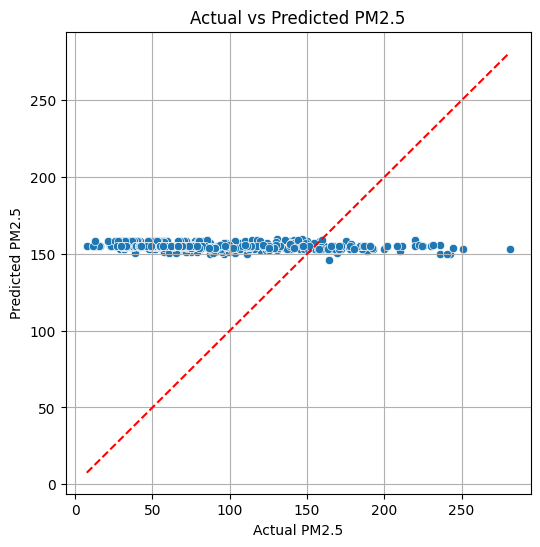

In [73]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Actual vs Predicted PM2.5")
plt.grid(True)
plt.show()

Residual Plot

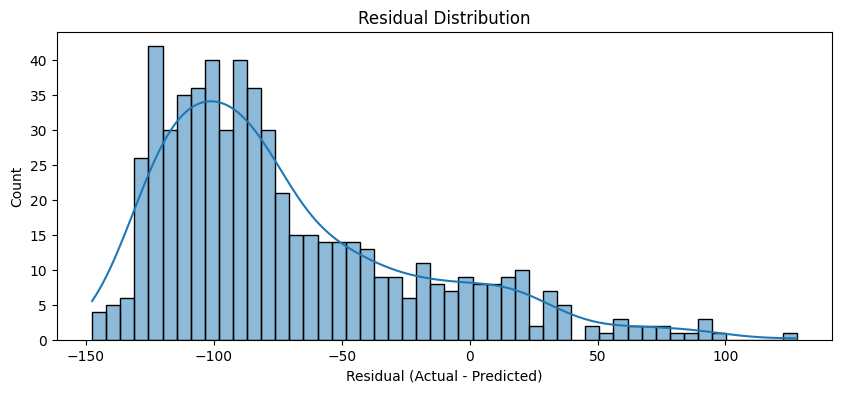

In [74]:
residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

**Time-based splitting**

In [75]:
import pandas as pd

Ensure datetime column is parsed

In [76]:
df['datetimeUtc'] = pd.to_datetime(df['datetimeUtc'])

Sort by datetime

In [77]:
df = df.sort_values('datetimeUtc').reset_index(drop=True)

Rename 'value' to 'pm25' if needed (optional)

In [78]:
df = df.rename(columns={'value': 'pm25'})

Drop rows with missing target

In [79]:
df = df.dropna(subset=['pm25'])

Define features and target

In [80]:
features = df.drop(columns=['pm25', 'datetimeUtc'])
target = df['pm25']

Time-based split — last 20% as test set

In [81]:
split_index = int(len(df) * 0.8)
X_train = features.iloc[:split_index]
X_test = features.iloc[split_index:]
y_train = target.iloc[:split_index]
y_test = target.iloc[split_index:]

Check time ranges

In [82]:
print("Train time:", df['datetimeUtc'].iloc[:split_index].min(), "to", df['datetimeUtc'].iloc[:split_index].max())
print("Test time:", df['datetimeUtc'].iloc[split_index:].min(), "to", df['datetimeUtc'].iloc[split_index:].max())

Train time: 2016-02-05 14:15:00+00:00 to 2025-05-18 11:15:00+00:00
Test time: 2025-05-18 11:15:00+00:00 to 2025-06-09 00:00:00+00:00


In [83]:
print(df.columns)

Index(['datetimeUtc', 'parameter', 'pm25', 'Month', 'Season'], dtype='object')


In [84]:
df['datetimeUtc'] = pd.to_datetime(df['datetimeUtc'])
df['hour'] = df['datetimeUtc'].dt.hour
df['dayofweek'] = df['datetimeUtc'].dt.dayofweek
df['month'] = df['datetimeUtc'].dt.month
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

lag/rolling features

In [85]:
for lag in [1, 3, 6, 12, 24]:
    df[f'pm25_lag_{lag}'] = df['pm25'].shift(lag)

df['pm25_roll_mean_6'] = df['pm25'].rolling(6).mean()
df['pm25_roll_std_6'] = df['pm25'].rolling(6).std()

**Check Your Data**

In [86]:
print(X_train.dtypes)

parameter    object
Month         int32
Season       object
dtype: object


**Drop or Encode Categorical Columns**

In [87]:
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

**Log-Transformed Training**

In [88]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

model = GradientBoostingRegressor()
model.fit(X_train, y_train_log)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

**Feature Engineering**

In [89]:
df['datetimeUtc'] = pd.to_datetime(df['datetimeUtc'])

Time-based features

In [90]:
df['hour'] = df['datetimeUtc'].dt.hour
df['dayofweek'] = df['datetimeUtc'].dt.dayofweek
df['month'] = df['datetimeUtc'].dt.month
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

Lag features

In [91]:
for lag in [1, 2, 3, 6, 12, 24]:
    df[f'pm25_lag_{lag}'] = df['pm25'].shift(lag)

Rolling mean features

In [92]:
df['pm25_roll_mean_6'] = df['pm25'].rolling(window=6).mean()
df['pm25_roll_std_6'] = df['pm25'].rolling(window=6).std()

**Apply Log Transformation**

In [93]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_test)

y_pred = np.expm1(y_pred_log)

**Use TimeSeries Cross-Validation**

In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Assume df is your main DataFrame

In [95]:
df['datetimeUtc'] = pd.to_datetime(df['datetimeUtc'])
df = df.sort_values('datetimeUtc').reset_index(drop=True)

Rename target column

In [96]:
df = df.rename(columns={'value': 'pm25'})

Drop rows where target is missing

In [97]:
df = df.dropna(subset=['pm25'])

Separate features and target

In [98]:
X = df.drop(columns=['pm25', 'datetimeUtc'])
y = df['pm25']

Convert categorical to numeric

In [99]:
X = pd.get_dummies(X)

Impute missing values in X

In [100]:
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

Initialize model and cross-validator

In [101]:
model = GradientBoostingRegressor()
tscv = TimeSeriesSplit(n_splits=5)

Score storage

In [102]:
mae_list = []
rmse_list = []
r2_list = []

Time series cross-validation

In [104]:
for i, (train_index, test_index) in enumerate(tscv.split(X_imputed)):
    X_train, X_test = X_imputed.iloc[train_index], X_imputed.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Fold {i+1} — MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

Fold 1 — MAE: 35.44, RMSE: 67.03, R²: 0.47
Fold 2 — MAE: 30.13, RMSE: 56.60, R²: 0.59
Fold 3 — MAE: 29.28, RMSE: 55.74, R²: 0.64
Fold 4 — MAE: 22.18, RMSE: 58.13, R²: 0.60
Fold 5 — MAE: 19.46, RMSE: 35.24, R²: 0.71


Average metrics

In [105]:
print("\n✅ Average MAE:", np.mean(mae_list))
print("✅ Average RMSE:", np.mean(rmse_list))
print("✅ Average R²:", np.mean(r2_list))


✅ Average MAE: 27.29670491337948
✅ Average RMSE: 54.545919155100265
✅ Average R²: 0.6023284801481412


# Checking the Model

**Visual Diagnostics**

In [106]:
from sklearn.ensemble import RandomForestRegressor

In [107]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

Prediction vs Actual

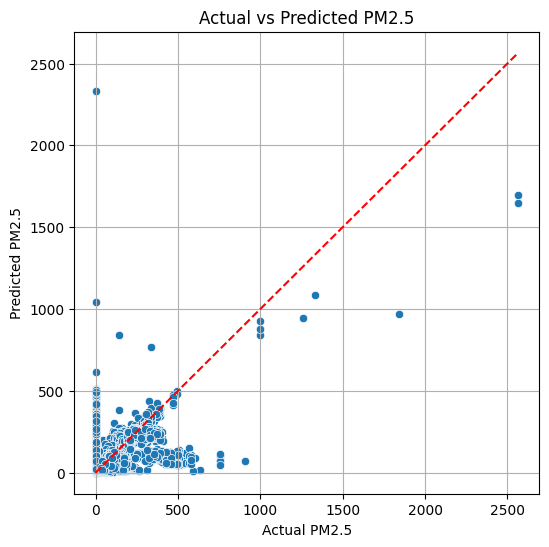

In [109]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Actual vs Predicted PM2.5")
plt.grid(True)
plt.show()

Residual Plot

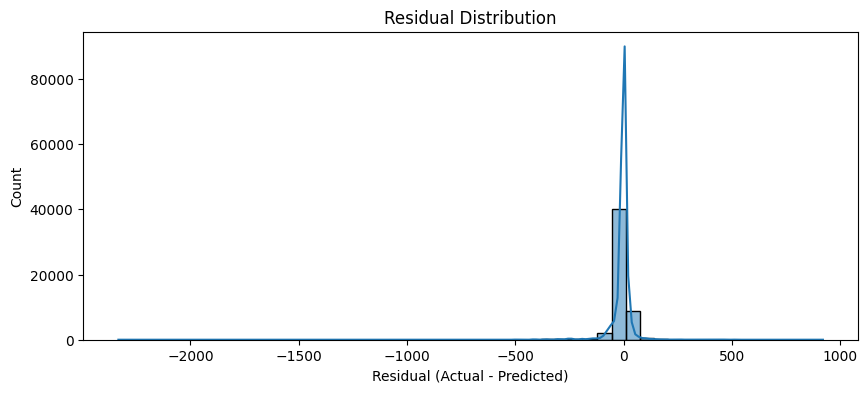

In [110]:
residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

**Model**

In [111]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

Define models

In [112]:
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

Cross-validation setup

In [113]:
tscv = TimeSeriesSplit(n_splits=5)

Evaluate each model

In [114]:
for name, model in models.items():
    print(f"\n🔹 Evaluating {name} model...")
    fold_mae, fold_rmse, fold_r2 = [], [], []

    for i, (train_index, test_index) in enumerate(tscv.split(X_imputed)):
        X_train, X_test = X_imputed.iloc[train_index], X_imputed.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Scale features inside the loop
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train and predict
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        fold_mae.append(mae)
        fold_rmse.append(rmse)
        fold_r2.append(r2)

        print(f"Fold {i+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")

    # Average results
    print(f"\n✅ Average Metrics for {name}:")
    print(f"MAE  : {np.mean(fold_mae):.2f}")
    print(f"RMSE : {np.mean(fold_rmse):.2f}")
    print(f"R²   : {np.mean(fold_r2):.4f}")
    print("-" * 40)


🔹 Evaluating Decision Tree model...
Fold 1: MAE=23.98, RMSE=62.80, R²=0.5379
Fold 2: MAE=25.44, RMSE=57.73, R²=0.5692
Fold 3: MAE=24.48, RMSE=55.19, R²=0.6495
Fold 4: MAE=18.26, RMSE=44.71, R²=0.7630
Fold 5: MAE=25.54, RMSE=69.77, R²=-0.1360

✅ Average Metrics for Decision Tree:
MAE  : 23.54
RMSE : 58.04
R²   : 0.4767
----------------------------------------

🔹 Evaluating Random Forest model...
Fold 1: MAE=19.20, RMSE=55.47, R²=0.6395
Fold 2: MAE=20.49, RMSE=47.24, R²=0.7115
Fold 3: MAE=19.73, RMSE=44.13, R²=0.7760
Fold 4: MAE=14.31, RMSE=46.16, R²=0.7474
Fold 5: MAE=19.15, RMSE=48.95, R²=0.4408

✅ Average Metrics for Random Forest:
MAE  : 18.58
RMSE : 48.39
R²   : 0.6630
----------------------------------------

🔹 Evaluating Gradient Boosting model...
Fold 1: MAE=35.44, RMSE=67.03, R²=0.4736
Fold 2: MAE=30.13, RMSE=56.60, R²=0.5859
Fold 3: MAE=29.28, RMSE=55.74, R²=0.6426
Fold 4: MAE=22.18, RMSE=58.13, R²=0.5994
Fold 5: MAE=19.46, RMSE=35.24, R²=0.7102

✅ Average Metrics for Gradient

# **Phase 5: Hyperparameter Tuning**

**Tune Key Models**

In [115]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='joblib')

Define model configurations

In [116]:
model_configs = {
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.05, 0.1],
            "max_depth": [3, 5]
        }
    }
}

TimeSeriesSplit

In [117]:
tscv = TimeSeriesSplit(n_splits=5)

Evaluate each model with GridSearch

In [118]:
for name, config in model_configs.items():
    print(f"\n🔹 Hyperparameter Tuning for {name}...")
    fold_mae, fold_rmse, fold_r2 = [], [], []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_imputed)):
        X_train, X_test = X_imputed.iloc[train_idx], X_imputed.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # GridSearch
        grid_search = GridSearchCV(
            estimator=config["model"],
            param_grid=config["params"],
            scoring='neg_mean_absolute_error',
            cv=TimeSeriesSplit(n_splits=3),
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_

        # Predict and evaluate
        y_pred = best_model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        fold_mae.append(mae)
        fold_rmse.append(rmse)
        fold_r2.append(r2)

        print(f"Fold {fold+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")
        print(f"  ➤ Best Params: {grid_search.best_params_}")

    # Fold average
    print(f"\n✅ Average Metrics for {name}:")
    print(f"MAE  : {np.mean(fold_mae):.2f}")
    print(f"RMSE : {np.mean(fold_rmse):.2f}")
    print(f"R²   : {np.mean(fold_r2):.4f}")
    print("-" * 50)


🔹 Hyperparameter Tuning for Decision Tree...
Fold 1: MAE=20.56, RMSE=58.36, R²=0.6009
  ➤ Best Params: {'max_depth': 10, 'min_samples_split': 10}
Fold 2: MAE=21.50, RMSE=48.24, R²=0.6991
  ➤ Best Params: {'max_depth': 10, 'min_samples_split': 5}
Fold 3: MAE=23.00, RMSE=48.59, R²=0.7283
  ➤ Best Params: {'max_depth': 10, 'min_samples_split': 5}
Fold 4: MAE=18.68, RMSE=45.28, R²=0.7569
  ➤ Best Params: {'max_depth': 10, 'min_samples_split': 10}
Fold 5: MAE=24.61, RMSE=64.66, R²=0.0242
  ➤ Best Params: {'max_depth': 10, 'min_samples_split': 2}

✅ Average Metrics for Decision Tree:
MAE  : 21.67
RMSE : 53.03
R²   : 0.5619
--------------------------------------------------

🔹 Hyperparameter Tuning for Random Forest...
Fold 1: MAE=20.68, RMSE=57.71, R²=0.6098
  ➤ Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Fold 2: MAE=20.52, RMSE=47.32, R²=0.7106
  ➤ Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Fold 3: MAE=19.73, RMSE=44.13, R²=0

# **Checking After Hyperparameter Tuning**

In [126]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='joblib')

Define the parameter distribution for RandomizedSearchCV

In [127]:
param_dist = {
    "n_estimators": randint(50, 150),
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2", None]
}

Base model

In [128]:
base_model = RandomForestRegressor(random_state=42)

Time series cross-validation

In [129]:
tscv = TimeSeriesSplit(n_splits=5)

Lists to store metrics for each fold

In [130]:
fold_mae, fold_rmse, fold_r2 = [], [], []

Hyperparameter on Random Forest

In [132]:
print(f"\n🔹 Hyperparameter Tuning for Random Forest...\n")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_imputed)):
    X_train, X_test = X_imputed.iloc[train_idx], X_imputed.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=3),
    n_jobs=-1,
    random_state=42,
    error_score=np.nan,
    verbose=0
)

    random_search.fit(X_train_scaled, y_train)
    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    fold_mae.append(mae)
    fold_rmse.append(rmse)
    fold_r2.append(r2)

    print(f"Fold {fold + 1}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")
    print(f"  ➤ Best Params: {random_search.best_params_}")


🔹 Hyperparameter Tuning for Random Forest...

Fold 1: MAE=19.16, RMSE=55.36, R²=0.6409
  ➤ Best Params: {'max_depth': None, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 111}
Fold 2: MAE=20.46, RMSE=47.22, R²=0.7117
  ➤ Best Params: {'max_depth': None, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 111}
Fold 3: MAE=19.69, RMSE=43.93, R²=0.7779
  ➤ Best Params: {'max_depth': 20, 'max_features': None, 'min_samples_split': 10, 'n_estimators': 137}
Fold 4: MAE=14.32, RMSE=45.95, R²=0.7497
  ➤ Best Params: {'max_depth': None, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 111}
Fold 5: MAE=19.44, RMSE=49.46, R²=0.4292
  ➤ Best Params: {'max_depth': None, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 111}


Average results

In [134]:
print(f"\n✅ Average Metrics for Random Forest:")
print(f"MAE  : {np.mean(fold_mae):.2f}")
print(f"RMSE : {np.mean(fold_rmse):.2f}")
print(f"R²   : {np.mean(fold_r2):.4f}")
print("-" * 50)


✅ Average Metrics for Random Forest:
MAE  : 18.61
RMSE : 48.38
R²   : 0.6619
--------------------------------------------------


# **Classification**

Define AQI Categories from PM2.5

In [135]:
def pm25_to_aqi_category(pm25):
    if pm25 <= 12:
        return 'Good'
    elif pm25 <= 35.4:
        return 'Moderate'
    elif pm25 <= 55.4:
        return 'Unhealthy for Sensitive Groups'
    elif pm25 <= 150.4:
        return 'Unhealthy'
    elif pm25 <= 250.4:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

Apply to the Target Column

In [136]:
df_wide['aqi_category'] = df_wide['pm25'].apply(pm25_to_aqi_category)

Train-Test Split

In [137]:
from sklearn.model_selection import train_test_split

features = ['pm25_lag1d', 'pm25_3d_avg', 'temperature_lag1d', 'temperature_7d_std']
target = 'aqi_category'

X = df_wide[features]
y = df_wide[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Scaling

In [138]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train Classifier (Random Forest)

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

Evaluation

In [140]:
print("📄 Classification Report:")
print(classification_report(y_test, y_pred))

📄 Classification Report:
                                precision    recall  f1-score   support

                          Good       0.00      0.00      0.00         1
                     Hazardous       1.00      0.50      0.67         2
                      Moderate       0.82      0.67      0.74        76
                     Unhealthy       0.89      0.96      0.92       580
Unhealthy for Sensitive Groups       0.84      0.77      0.81       220
                Very Unhealthy       0.94      0.84      0.89        92

                      accuracy                           0.88       971
                     macro avg       0.75      0.62      0.67       971
                  weighted avg       0.88      0.88      0.88       971



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix

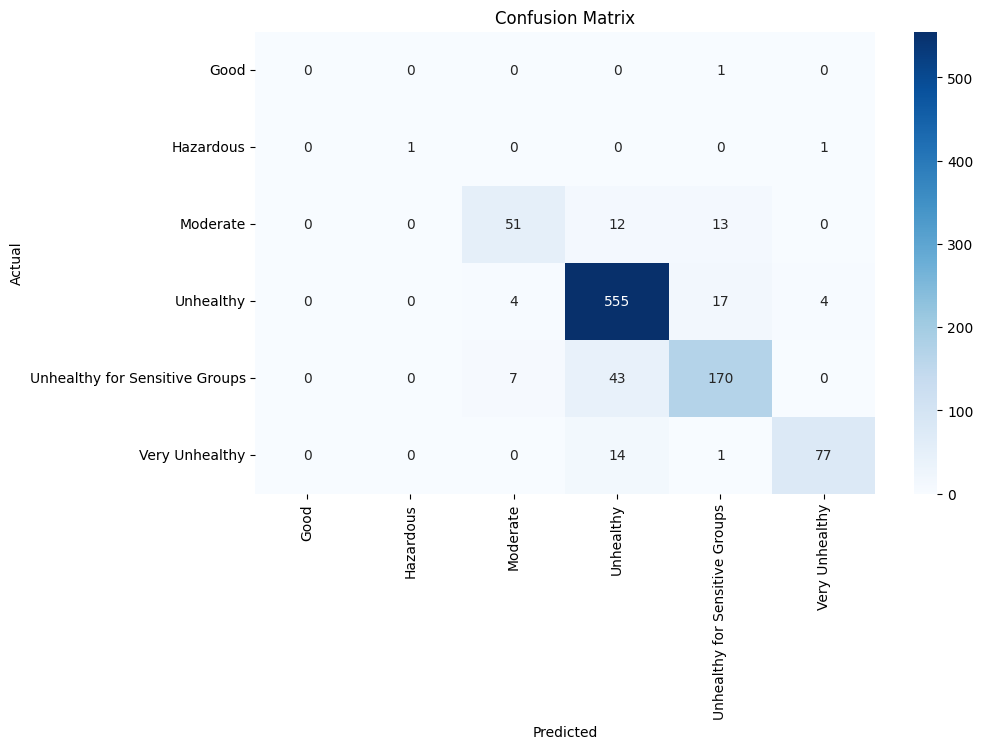

In [141]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()